In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib import font_manager, rc, cm                
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import folium
import json
from folium import plugins
print(folium.__version__)

font_path = './font/GmarketSansTTFMedium.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)


0.12.1.post1


In [26]:
# 데이터 불러오기

df = pd.read_excel('./data/통합파일.xlsx', index_col=1)
df.drop('지 역', axis=1, inplace=True)
df

,호당 매매가(천원),호당 전세가(천원),전세가율(%),건축허가면적(m2),지하철역 수(개),주민등록세대수(호),은행 점포수(개)
SIG_KOR_NM,,,,,,,
강남구,190725,85901,45.039193,1615344,33,234233,283
강동구,93878,46026,49.027461,1099704,13,201613,51
강북구,66844,37170,55.607085,482673,11,144536,24
강서구,78990,39767,50.344347,2104922,22,271175,63
관악구,72896,42716,58.598551,330146,4,276597,36
...,...,...,...,...,...,...,...
파주시,32642,26435,80.984621,3607188,7,211916,33
평택시,24993,19066,76.285360,5178955,5,262097,43
포천시,15951,13799,86.508683,1153610,0,73584,12


In [27]:
# Min-Max 정규화

data = df[['호당 매매가(천원)', '호당 전세가(천원)','전세가율(%)']]

scaler = MinMaxScaler()
data_scale = scaler.fit_transform(data)

# ndata = pd.DataFrame(data_scale)
# ndata.index=data.index
# ndata.columns=data.bin

C:\Users\user\anaconda3\envs\pydatavenv\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

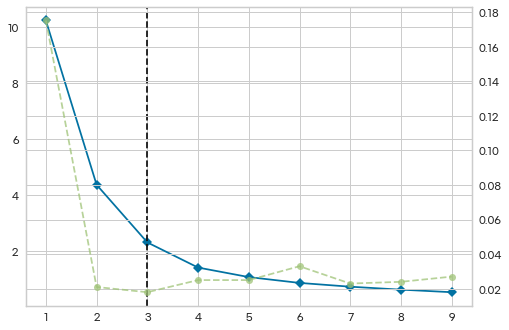

In [28]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data_scale)

In [29]:
k = 3

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(data_scale)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
df['cluster'] = model.fit_predict(data_scale)
print(df.head())

            호당 매매가(천원)  호당 전세가(천원)    전세가율(%)  건축허가면적(m2)  지하철역 수(개)  \
SIG_KOR_NM                                                             
강남구             190725       85901  45.039193     1615344         33   
강동구              93878       46026  49.027461     1099704         13   
강북구              66844       37170  55.607085      482673         11   
강서구              78990       39767  50.344347     2104922         22   
관악구              72896       42716  58.598551      330146          4   

            주민등록세대수(호)  은행 점포수(개)  cluster  
SIG_KOR_NM                                  
강남구             234233        283        1  
강동구             201613         51        0  
강북구             144536         24        0  
강서구             271175         63        0  
관악구             276597         36        0  


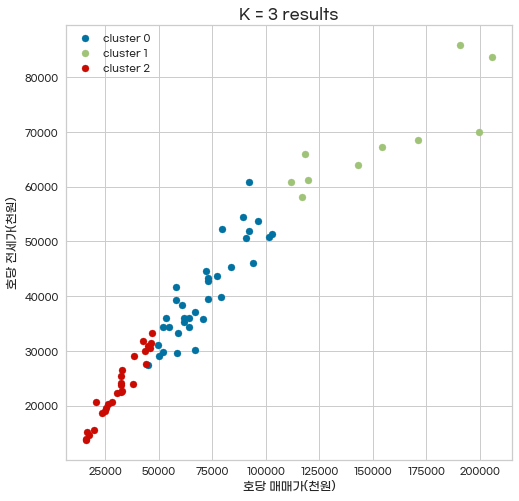

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(df.loc[df['cluster'] == i, '호당 매매가(천원)'], df.loc[df['cluster'] == i, '호당 전세가(천원)'], 
                label = 'cluster ' + str(i))
    
plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('호당 매매가(천원)', size = 12)
plt.ylabel('호당 전세가(천원)', size = 12)
plt.show()

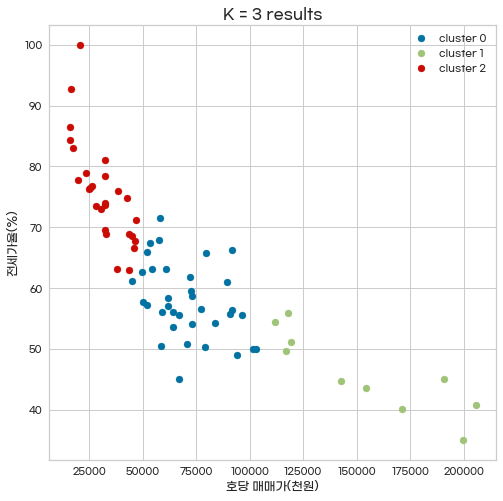

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(df.loc[df['cluster'] == i, '호당 매매가(천원)'], df.loc[df['cluster'] == i, '전세가율(%)'], 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('호당 매매가(천원)', size = 12)
plt.ylabel('전세가율(%)', size = 12)
plt.show()

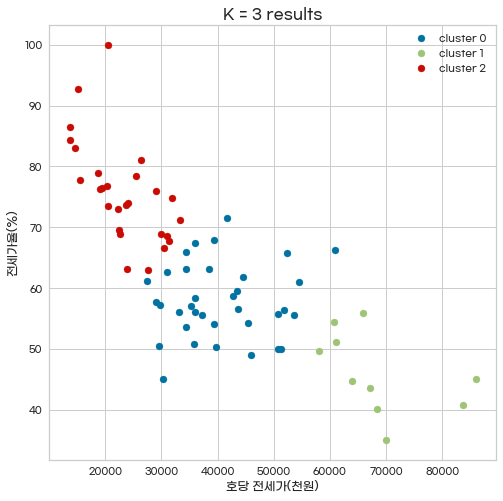

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(df.loc[df['cluster'] == i, '호당 전세가(천원)'], df.loc[df['cluster'] == i, '전세가율(%)'], 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('호당 전세가(천원)', size = 12)
plt.ylabel('전세가율(%)', size = 12)
plt.show()

In [33]:
clu1 = df[(df['cluster'] == 0)]
clu2 = df[(df['cluster'] == 1)]
clu3 = df[(df['cluster'] == 2)]

In [34]:
# 군집분석 지도 시각화

state_geo = 'data/전국_군집분석용.json'
state_geo2 = json.load(open(state_geo, encoding ="utf-8"))

In [35]:
m = folium.Map(location = [37.5760, 126.9769], tiles="OpenStreetMap", zoom_start=9)

choropleth = folium.Choropleth(
    geo_data=state_geo2,
    name = "지도",
    data = df,
    columns=(df.index, "cluster"),
    fill_color='Spectral',
    key_on="feature.properties.SIG_KOR_NM",
    fill_opactiy = 1,
    line_opacity = 0.5,
    nan_fill_color='#FAEB78',
    nan_fill_opacity=0,
).add_to(m)

In [36]:
m

m.save('군집분석_시각화.html')

In [ ]:
clu_re1 = clu1[["호당 매매가(천원)", "호당 전세가(천원)", "전세가율(%)"]]
clu_re2 = clu2[["호당 매매가(천원)", "호당 전세가(천원)", "전세가율(%)"]]
clu_re3 = clu3[["호당 매매가(천원)", "호당 전세가(천원)", "전세가율(%)"]]

cl1 = pd.DataFrame(clu_re1.mean())
cl2 = pd.DataFrame(clu_re2.mean())
cl3 = pd.DataFrame(clu_re3.mean())

In [78]:
result = pd.concat([cl1, cl2, cl3],axis=1)
result.columns = ["군집1", '군집2', '군집3']
result2 = result.loc[['전세가율(%)']].round(1)
result1 = result.loc[["호당 매매가(천원)", "호당 전세가(천원)"]].astype("int")

result = pd.concat([result1, result2], axis = 0)
result

,군집1,군집2,군집3
호당 매매가(천원),70784.0,153056.0,31518.0
호당 전세가(천원),40560.0,68493.0,23219.0
전세가율(%),57.9,46.0,75.7


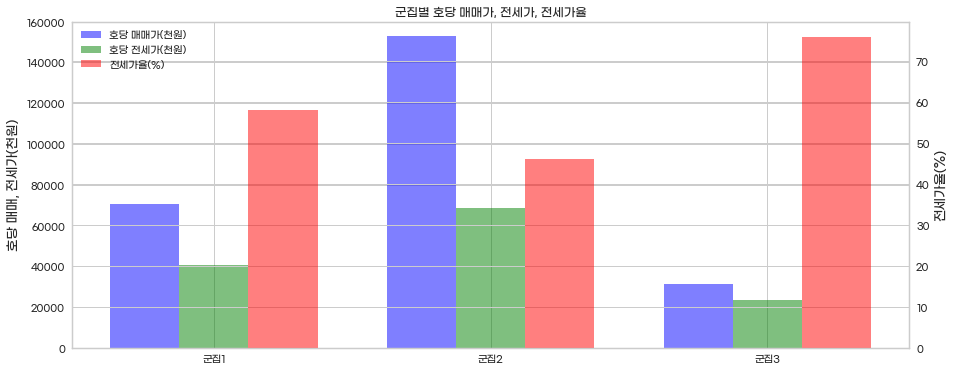

In [165]:
colors = sns.color_palette('Blues',len(result.columns))

fig, ax1= plt.subplots(figsize=(15,6))
bar_width = 0.25


# 연도가 4개이므로 0, 1, 2, 3 위치를 기준으로 삼음
index = np.arange(3)
year = ['군집1', '군집2', '군집3']

ax1.bar(index, result.T['호당 매매가(천원)'], bar_width, alpha=0.5, color='blue', label='호당 매매가(천원)')
ax1.bar(index + bar_width, result.T['호당 전세가(천원)'], bar_width, alpha=0.5, color='green', label='호당 전세가(천원)')
plt.ylim(0, 160000)
plt.ylabel('호당 매매, 전세가(천원)', size = 13)

ax2 = ax1.twinx()
ax2.bar(index + bar_width * 2, result.T['전세가율(%)'], bar_width, alpha=0.5, color='red', label='전세가율(%)')

# x축 위치를 정 가운데로 조정하고 x축의 텍스트를 year 정보와 매칭
plt.xticks(np.arange(bar_width, 3 + bar_width, 1), year)

# x축, y축 이름 및 범례 설정
ax.set_xticklabels(labels=result.index, fontsize=11)
plt.xlabel('호당', size = 13)
plt.ylabel('전세가율(%)', size = 13)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.91))
plt.title('군집별 호당 매매가, 전세가, 전세가율')
plt.show()